# ETF Spread Trading Example

### Libraries, Functions, and Preprocessing

In [1]:
library(tidyverse)
library(Quandl)
library(lubridate)
library(knitr)
library(zoo)
library(xts)
library(PerformanceAnalytics)
Quandl.api_key("QUANDL_API_KEY")

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.1     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Attaching package: 'xts'


The following objects are masked from 'package:dplyr':

    first, last



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'PerformanceAnalytics'


The following object is masked from 'package:graphics':

    legend




In [2]:
##########################################
####     Generate Spread Signals      ####
##########################################

generate_signals <- function(spread,g,j){
  
  signal <- vector()
  
    # categorize first spread
  if(spread[1]>g){
    signal[1] = 'short'
  } else if(spread[1]< -g){
    signal[1] = 'long'
  } else{
    signal[1] = 'neutral'
  }
  
  for (t in 2:length(spread)) {
    if (signal[t-1] == 'neutral') {  # if currently neutral
      if (spread[t] > g) {
        signal[t] = 'short' # open short position
      } 
      else if(spread[t] < -g) {
        signal[t] = 'long' # open long position
      }
      else signal[t] <- 'neutral' # stay neutral
    }
    else if (signal[t-1] == 'short') {  #if currently short
      if (spread[t] >= j){
        signal[t] = 'short' # stay short
      }
      else if((spread[t] < j)&(spread[t] > -g)){
        signal[t] = 'neutral' # close short position
      }
      else {
        signal[t] = 'long' # switch to long position
      }
    }
    else {  #if currently long
      if (spread[t] < -j) {
        signal[t] = 'long' # stay long
      }
      else if((spread[t] > -j)&(spread[t] < g)){
        signal[t] <- 'neutral' # close long position
      }
      else {
        signal[t] <- 'short' # switch to short position
      }
    }
  }
  return(signal)
}

##########################################
####     Generate Monthly Trades      ####
##########################################


get_monthly_trades <- function(period_data,s) {

  month.trades <- period_data %>% 
    mutate(long_PBE = position_bod=='long',
           short_PBE = position_bod=='short',
           long_XBI = position_bod=='short',
           short_XBI = position_bod=='long')
  
  month.positions <- month.trades %>%
    mutate(PBE_position_eod = ifelse(signal_chg&(position_eod=='long'), PBE_new_trade_size,
                                     ifelse(signal_chg&(position_eod=='short'),-PBE_new_trade_size,
                                            ifelse(position_eod=='neutral',0,NA))),
           XBI_position_eod = ifelse(signal_chg&(position_eod=='short'), XBI_new_trade_size,
                                     ifelse(signal_chg&(position_eod=='long'),-XBI_new_trade_size,
                                            ifelse(position_eod=='neutral',0,NA)))) %>%
    mutate(PBE_position_eod = na.locf(PBE_position_eod, na.rm = F),
           XBI_position_eod = na.locf(XBI_position_eod, na.rm = F)) %>%
    select(-c(PBE_new_trade_size, XBI_new_trade_size)) %>%
    mutate(trade_mv = ifelse(signal_chg&(position_eod!='neutral'),abs(PBE_adj_close*PBE_position_eod) + abs(XBI_adj_close*XBI_position_eod),NA),
           trade_mv = ifelse(signal_chg&(position_eod=='neutral'),0,trade_mv),
           trade_mv = na.locf(trade_mv, na.rm = F),
           trade_mv_bod = lag(trade_mv,1))
  
  daily_P_L <- month.positions %>%
      mutate(PBE_position_bod = lag(PBE_position_eod,1,default=0),
             XBI_position_bod = lag(XBI_position_eod,1,default=0),
             PBE_P_L = (PBE_position_bod*PBE_adj_close)-(PBE_position_bod*lag(PBE_adj_close,1)),
             XBI_P_L = (XBI_position_bod*XBI_adj_close)-(XBI_position_bod*lag(XBI_adj_close,1)),
             PBE_P_L = replace_na(PBE_P_L,0),
             XBI_P_L = replace_na(XBI_P_L,0),
             daily_P_L = PBE_P_L + XBI_P_L)%>%
    group_by(grp = lag(cumsum(signal_chg), default = 1)) %>%
    mutate(current_position_P_L = cumsum(daily_P_L)) %>%
    ungroup()%>%
    mutate(trade_gain_loss = ifelse(trade_mv_bod>0,current_position_P_L/trade_mv_bod,0),
           stop_loss = trade_gain_loss < -s)

  if(suppressWarnings(max(daily_P_L$stop_loss,na.rm=T))>0){
    stop_date = suppressWarnings(min(daily_P_L$date[daily_P_L$stop_loss],na.rm=T))
    daily_P_L$position_eod[daily_P_L$date>=stop_date] = 'neutral'
    daily_P_L$position_bod[daily_P_L$date>stop_date] = 'neutral'
    daily_P_L$trade_mv[daily_P_L$date>stop_date] = 0
    daily_P_L$daily_P_L[daily_P_L$date>stop_date] = 0
    daily_P_L$current_position_P_L[daily_P_L$date>stop_date] = 0
    
    rtn_values <- daily_P_L %>%
      mutate(monthly_cummulative_P_L = cumsum(daily_P_L)) %>%
      select(date, rtn_spread, position_eod, position_bod, signal_chg, trade_mv, daily_P_L, current_position_P_L, monthly_cummulative_P_L, stop_loss)
    
  } else {
    
    rtn_values <- daily_P_L %>%
      mutate(monthly_cummulative_P_L = cumsum(daily_P_L)) %>%
      select(date, rtn_spread, position_eod, position_bod, signal_chg, trade_mv, daily_P_L, current_position_P_L, monthly_cummulative_P_L, stop_loss)
    }
  
  return(rtn_values)

}

##########################################
####     Generate All the data        ####
##########################################

generate_spreads_and_signals <- function(M,g,j,s) {
    rtn_spreads <- par_xy %>% 
      arrange(date) %>%
      mutate(PBE_rtn = PBE_adj_close/lag(PBE_adj_close,M)-1, 
             XBI_rtn = XBI_adj_close/lag(XBI_adj_close,M)-1,
             rtn_spread = PBE_rtn-XBI_rtn) %>%
      select(date,PBE_rtn, PBE_adj_close, XBI_adj_close, XBI_rtn, rtn_spread, PBE_new_trade_size, XBI_new_trade_size) %>%
      drop_na()

    all_signals <- rtn_spreads %>%
      mutate(position_eod = generate_signals(rtn_spread,g,j), # this position signal is as of end of day
             position_bod = lag(position_eod,1)) %>% # we'll use these signals for returns
      select(-c(PBE_rtn, XBI_rtn)) %>%
      group_by(month(date),year(date)) %>%
      mutate(position_bod = ifelse(date==min(date),'neutral',position_bod),#, # start each month at neutral
             position_eod = ifelse(date==max(date),'neutral',position_eod),
             signal_chg = position_bod!=position_eod) %>% # force neutral at end of period
      ungroup() %>%
      select(-c(`month(date)`,`year(date)`))
    
    months <- seq.Date(as.Date('2020-01-01'),as.Date('2021-11-01'),by='month')

    all_trades <- tibble()

    for(targ.month in months){

      new_monthly_data <- all_signals %>% filter((month(date) == month(as.Date(targ.month)))&(year(date) == year(as.Date(targ.month))))
      new_trades <- get_monthly_trades(new_monthly_data,s)

      all_trades <- all_trades %>% bind_rows(new_trades)
    }

    return(all_trades)    

}

fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }


In [3]:


# PBE Benchmark: Dynamic Biotechnology & Genome Intellidex Index (Multi factor selection process tiered weighting methodology 31 holdings)
# XBI Benchmark: S&P Biotechnology Select Industry Index (top n companies by market cap and equal weighted 190 positions)

# It is ok to use up the latest date for this data.
fama_french_factors <- read_csv('F-F_Research_Data_Factors_daily.csv', skip = 3) %>%
  rename(Date = `...1`) %>%
  mutate(Date = as.Date(as.character(Date),format = '%Y%m%d'))

par_xy <- c('PBE','XBI')

PBE <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker='PBE') %>%
  filter((date >= as.Date('2019-12-03'))&(date <= as.Date('2021-12-31')))

XBI <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker='XBI') %>%
  filter((date >= as.Date('2019-12-03'))&(date <= as.Date('2021-12-31')))

PBE <- PBE %>% 
  mutate(dollar_volm = adj_close*adj_volume,
         PBE_15d_med_volm = rollapply(dollar_volm,width = 15,FUN = median,fill=NA, align='right')) %>%
  select(date,adj_close,PBE_15d_med_volm) %>%
  rename(PBE_adj_close = adj_close)

XBI <- XBI %>% 
  mutate(dollar_volm = adj_close*adj_volume,
         XBI_15d_med_volm = rollapply(dollar_volm,width = 15,FUN = median,fill=NA, align='right')) %>%
  select(date,adj_close,XBI_15d_med_volm) %>%
  rename(XBI_adj_close = adj_close)

par_xy <- PBE %>%
  full_join(XBI,by='date') %>%
  drop_na() %>%
  group_by(date) %>%
  mutate(Nt = min(PBE_15d_med_volm,XBI_15d_med_volm)) %>%
  ungroup() %>%
  mutate(PBE_new_trade_size = round((Nt/100)/PBE_adj_close),
         XBI_new_trade_size = round((Nt/100)/XBI_adj_close))

K = max(par_xy$Nt)*2

New names:
* `` -> ...1

Rows: 25127 Columns: 5

-- Column specification --------------------------------------------------------
Delimiter: ","
chr (1): ...1
dbl (4): Mkt-RF, SMB, HML, RF


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
"One or more parsing issues, see `problems()` for details"


### Defining Parameters

In [4]:
previous_year <- Quandl.datatable('QUOTEMEDIA/PRICES', ticker=c('PBE','XBI')) %>%
  filter((date >= as.Date('2018-12-03'))&(date <= as.Date('2019-12-03'))) %>%
  select(date, ticker, adj_close) %>%
  pivot_wider(id_cols = date, names_from = ticker, values_from = adj_close)

rtn_dist <- previous_year %>% 
    arrange(date) %>%
    mutate(PBE_rtn_3 = PBE/lag(PBE,3)-1, 
           XBI_rtn_3 = XBI/lag(XBI,3)-1,
           rtn_spread_3 = PBE_rtn_3-XBI_rtn_3,
           PBE_rtn_5 = PBE/lag(PBE,5)-1, 
           XBI_rtn_5 = XBI/lag(XBI,5)-1,
           rtn_spread_5 = PBE_rtn_5-XBI_rtn_5,
          PBE_rtn_10 = PBE/lag(PBE,10)-1, 
           XBI_rtn_10 = XBI/lag(XBI,10)-1,
           rtn_spread_10 = PBE_rtn_10-XBI_rtn_10,
          PBE_rtn_15 = PBE/lag(PBE,15)-1, 
           XBI_rtn_15 = XBI/lag(XBI,15)-1,
           rtn_spread_15 = PBE_rtn_15-XBI_rtn_15) %>%
      select(date,rtn_spread_3,rtn_spread_5, rtn_spread_10,rtn_spread_15) %>%
      drop_na()

rtn_dist %>%
    pivot_longer(-date,names_to='M') %>%
    filter(value>0) %>%
    group_by(M) %>%
    summarize(mean_val = mean(value),
              median_val = median(value),
              bottom_quartile = quantile(value,0.25),
              top_decile = quantile(value,0.9)) %>%
    mutate_if(is.numeric,round,3) %>%
    kable(caption = 'Stats for Spread Difference when PBE Outperforms XBI')

rtn_dist %>%
    pivot_longer(-date, names_to='M') %>%
    filter(value<0) %>%
    group_by(M) %>%
    summarize(mean_val = mean(abs(value)),
              median_val = median(abs(value)),
              bottom_quartile = quantile(abs(value),0.25),
              top_decile = quantile(abs(value),0.9)) %>%
    mutate_if(is.numeric,round,3) %>%
    kable(caption = 'Stats for Spread Difference when XBI Outperforms PBE')



Table: Stats for Spread Difference when PBE Outperforms XBI

|M             | mean_val| median_val| bottom_quartile| top_decile|
|:-------------|--------:|----------:|---------------:|----------:|
|rtn_spread_10 |    0.012|      0.010|           0.005|      0.026|
|rtn_spread_15 |    0.014|      0.012|           0.004|      0.029|
|rtn_spread_3  |    0.006|      0.004|           0.002|      0.014|
|rtn_spread_5  |    0.008|      0.006|           0.004|      0.015|



Table: Stats for Spread Difference when XBI Outperforms PBE

|M             | mean_val| median_val| bottom_quartile| top_decile|
|:-------------|--------:|----------:|---------------:|----------:|
|rtn_spread_10 |    0.017|      0.013|           0.006|      0.039|
|rtn_spread_15 |    0.017|      0.014|           0.007|      0.040|
|rtn_spread_3  |    0.008|      0.006|           0.002|      0.018|
|rtn_spread_5  |    0.011|      0.008|           0.003|      0.027|

For length of returns, we will test a 3-day return, 5-day return, 10-day return, and 15-day return. The top 90% of spread values are between 1.4% and 4% so we will set G to be between 1%, 1.5%, 2%, 2.5%, 3%, and 3.5%. The bottom 25% of spread values are between 0.004 and 0.015 so we will try setting J to 0.5%, 1%, and 1.5%. We will be conservative with a stop loss so we will test 0.5%, 1%, and 1.5%.


### Find best performing strategy

In [5]:
# Variables 
# j: less than j enter position
# g: greater than g enter position
# s: stop loss parameter
# M: number of days return

Ms <- c(3,5,10)
Gs <- c(0.01, 0.015, 0.02, 0.025, 0.03, 0.035)
Js <- c(0.005, 0.01, 0.015)
Ss <- seq(0.005,0.015,0.005)

strategies_to_test <- expand.grid(M=Ms,g=Gs,j=Js,s=Ss) %>% filter(g>j)

strategies <- tibble()

for(i in 1:nrow(strategies_to_test)){
    
    strat_rtns = generate_spreads_and_signals(M = strategies_to_test$M[i],
                                              g = strategies_to_test$g[i],
                                              j = strategies_to_test$j[i],
                                              s = strategies_to_test$s[i]) %>%
        mutate(strategy_mv = K+cumsum(daily_P_L),
              strategy_daily_rtn = strategy_mv/lag(strategy_mv,1)-1,
              strategy_daily_rtn = replace_na(strategy_daily_rtn,0))
    
    sortino = SortinoRatio(R=strat_rtns$strategy_daily_rtn,MAR=0)
    calmar = CalmarRatio(R=as.xts(strat_rtns$strategy_daily_rtn,order.by=strat_rtns$date))
    max_drawdown = maxDrawdown(R=as.xts(strat_rtns$strategy_daily_rtn,order.by=strat_rtns$date))
    strategy_return = sum(strat_rtns$daily_P_L)/K
    
    strategy_results <- tibble(M = strategies_to_test$M[i],
                               g = strategies_to_test$g[i],
                               j = strategies_to_test$j[i],
                               s = strategies_to_test$s[i],
                               total_return=strategy_return,
                               sortino_ratio = sortino[1,1],
                               calmar_ratio = calmar[1,1],
                               max_drawdown = max_drawdown)
    
    strategies <- strategies %>% bind_rows(strategy_results)
    
}

In [6]:
best_strategies <- strategies %>% arrange(desc(sortino_ratio)) %>% head(4)

top_strat_1 = generate_spreads_and_signals(M = best_strategies$M[1],
                                          g = best_strategies$g[1],
                                          j = best_strategies$j[1],
                                          s = best_strategies$s[1])  %>%
        mutate(strategy_mv = K+cumsum(daily_P_L),
              strategy_daily_rtn = strategy_mv/lag(strategy_mv,1)-1,
              strategy_daily_rtn = replace_na(strategy_daily_rtn,0),
               M = best_strategies$M[1],
               g = best_strategies$g[1],
               j = best_strategies$j[1],
               s = best_strategies$s[1],
              strategy = "Strategy One") %>%
select(strategy, date, signal_chg, rtn_spread, strategy_daily_rtn,M,g,j,s)

top_strat_2 = generate_spreads_and_signals(M = best_strategies$M[2],
                                          g = best_strategies$g[2],
                                          j = best_strategies$j[2],
                                          s = best_strategies$s[2])  %>%
        mutate(strategy_mv = K+cumsum(daily_P_L),
              strategy_daily_rtn = strategy_mv/lag(strategy_mv,1)-1,
              strategy_daily_rtn = replace_na(strategy_daily_rtn,0),
               M = best_strategies$M[2],
               g = best_strategies$g[2],
               j = best_strategies$j[2],
               s = best_strategies$s[2],
              strategy = "Strategy Two") %>%
        select(strategy, date, signal_chg, rtn_spread, strategy_daily_rtn,M,g,j,s)

top_strat_3 = generate_spreads_and_signals(M = best_strategies$M[3],
                                          g = best_strategies$g[3],
                                          j = best_strategies$j[3],
                                          s = best_strategies$s[3])  %>%
        mutate(strategy_mv = K+cumsum(daily_P_L),
              strategy_daily_rtn = strategy_mv/lag(strategy_mv,1)-1,
              strategy_daily_rtn = replace_na(strategy_daily_rtn,0),
               M = best_strategies$M[3],
               g = best_strategies$g[3],
               j = best_strategies$j[3],
               s = best_strategies$s[3],
              strategy = "Strategy Three") %>%
        select(strategy, date, signal_chg, rtn_spread, strategy_daily_rtn,M,g,j,s)

top_strat_4 = generate_spreads_and_signals(M = best_strategies$M[4],
                                          g = best_strategies$g[4],
                                          j = best_strategies$j[4],
                                          s = best_strategies$s[4])  %>%
        mutate(strategy_mv = K+cumsum(daily_P_L),
              strategy_daily_rtn = strategy_mv/lag(strategy_mv,1)-1,
              strategy_daily_rtn = replace_na(strategy_daily_rtn,0),
               M = best_strategies$M[4],
               g = best_strategies$g[4],
               j = best_strategies$j[4],
               s = best_strategies$s[4],
              strategy = "Strategy Four") %>%
        select(strategy, date, signal_chg, rtn_spread, strategy_daily_rtn,M,g,j,s)

In [7]:
fig(15,8)
performance_metrics_kable = best_strategies %>%
    mutate(Strategy = c('Strategy One','Strategy Two', 'Strategy Three', 'Strategy Four')) %>%
    select(Strategy, M, g,j,s,total_return, sortino_ratio, calmar_ratio, max_drawdown) %>%
    rename(`Total Return (%)`=total_return,
           `Sortino Ratio`=sortino_ratio,
           `Calmar Ratio`=calmar_ratio,
           `Max Drawdown`=max_drawdown) %>%
    kable(caption = 'Top Strategies by Sortino Ratio, Total Return, and Calmar Ratio')

top_strategy_rtns <- top_strat_1 %>%
    bind_rows(top_strat_2) %>% 
    bind_rows(top_strat_3) %>%
    bind_rows(top_strat_4)

spread_range_plot <- top_strategy_rtns %>%
    mutate(strategy = factor(strategy,levels = c('Strategy One','Strategy Two', 'Strategy Three', 'Strategy Four'))) %>%
    ggplot(aes(x=date,y=rtn_spread)) +
    geom_line() +
    geom_ribbon(aes(x=date,ymin=j,ymax=g),alpha=0.3) +
    geom_ribbon(aes(x=date,ymin=-g,ymax=-j),alpha=0.3) +
    facet_wrap(~strategy) +
    theme_bw() +
    theme(text = element_text(size=20),
         axis.text.x = element_text(angle=45, hjust=1)) +
    labs(title = 'Spread Ranges by Trading Strategies',x='Date',y='Return Spread')

cummulative_return_plot <- top_strategy_rtns %>%
    group_by(strategy) %>%
    mutate(cummulative_rtn = cumprod(1+strategy_daily_rtn)-1) %>%
    ungroup() %>% 
    mutate(strategy = factor(strategy,levels = c('Strategy One','Strategy Two', 'Strategy Three', 'Strategy Four'))) %>%
    ggplot(aes(x=date,y=cummulative_rtn)) +
    geom_line() +
    scale_y_continuous(labels=scales::percent) +
    facet_wrap(~strategy) +
    theme_bw() +
    theme(text = element_text(size=20),
         axis.text.x = element_text(angle=45, hjust=1)) +
    labs(title = 'Cummulative Return by Trading Strategies',x='Date',y='Return Spread')

strat_rtns_FF_factors <- top_strategy_rtns %>%
    select(strategy, date,strategy_daily_rtn) %>%
    left_join(fama_french_factors,by=c('date'='Date')) %>%
    drop_na()

strat_corr_kable <- strat_rtns_FF_factors %>%
    mutate(strategy = factor(strategy,levels = c('Strategy One','Strategy Two', 'Strategy Three', 'Strategy Four'))) %>%
    group_by(strategy) %>%
    summarize(`Mkt-RF` = cor(strategy_daily_rtn,`Mkt-RF`/100),
              SMB = cor(strategy_daily_rtn,SMB/100),
              HML = cor(strategy_daily_rtn,HML/100),
              RF = cor(strategy_daily_rtn,RF/100)) %>%
    mutate_if(is.numeric,round,4) %>%
    kable(caption = 'Correlation Of Fama-French Factors and Strategies')

### Analysis

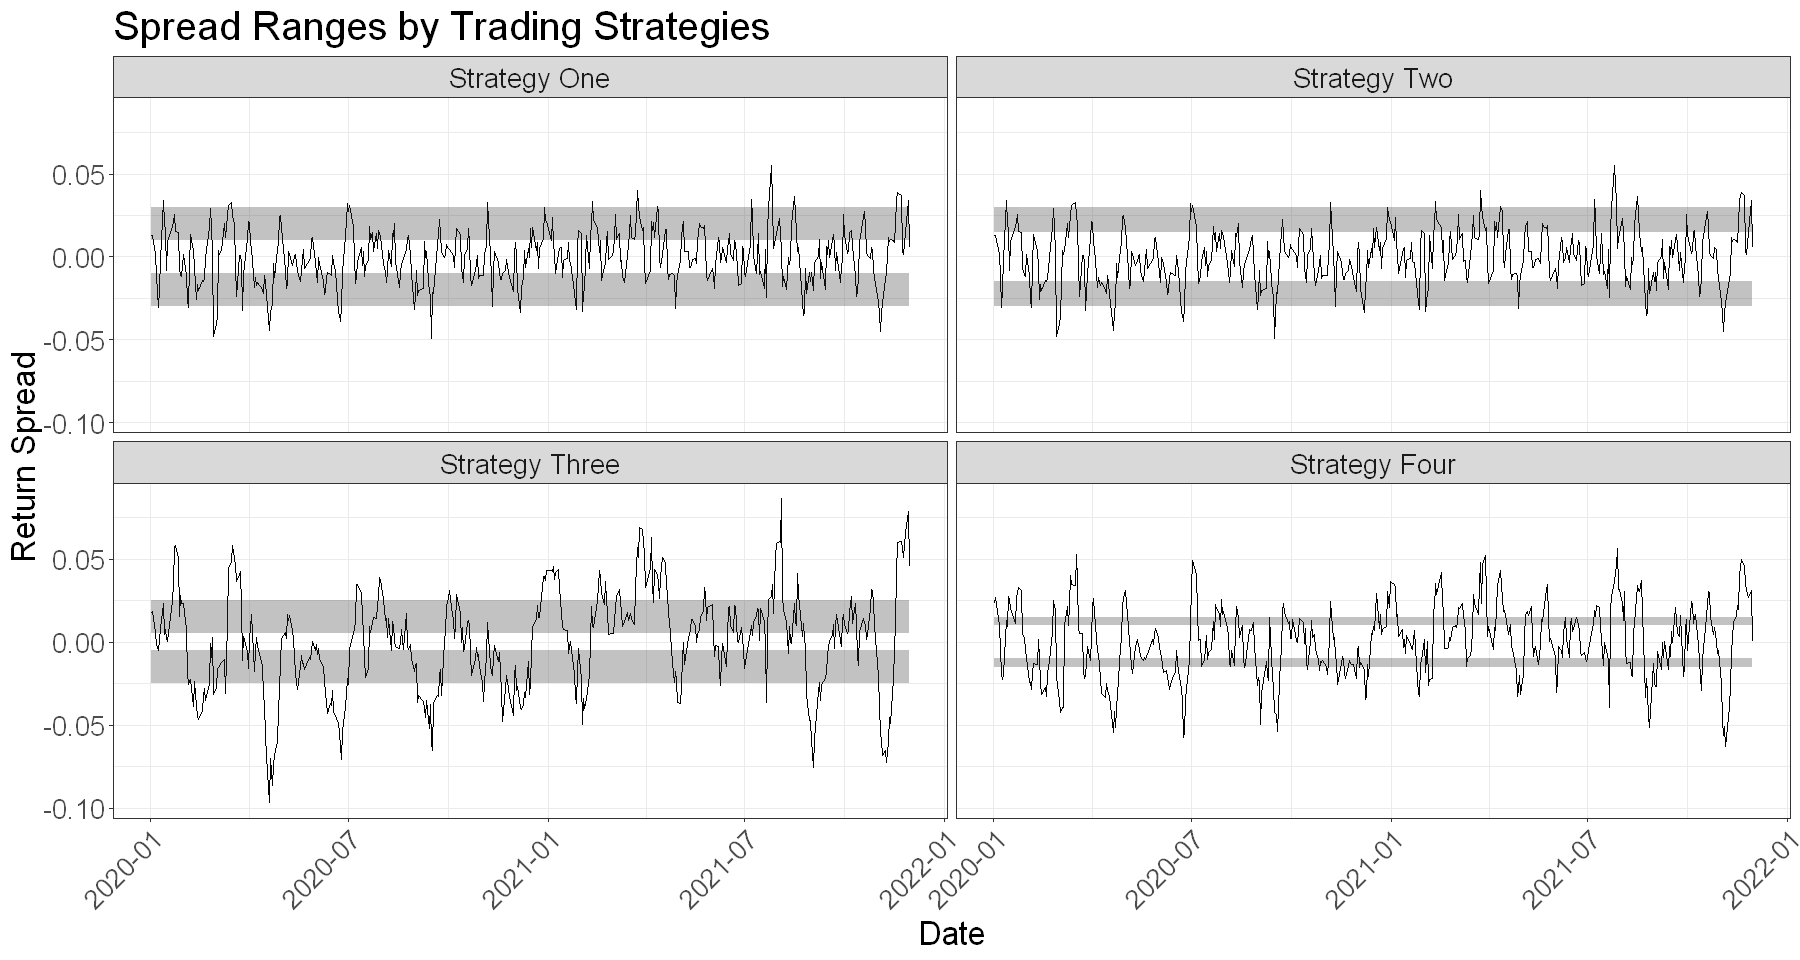

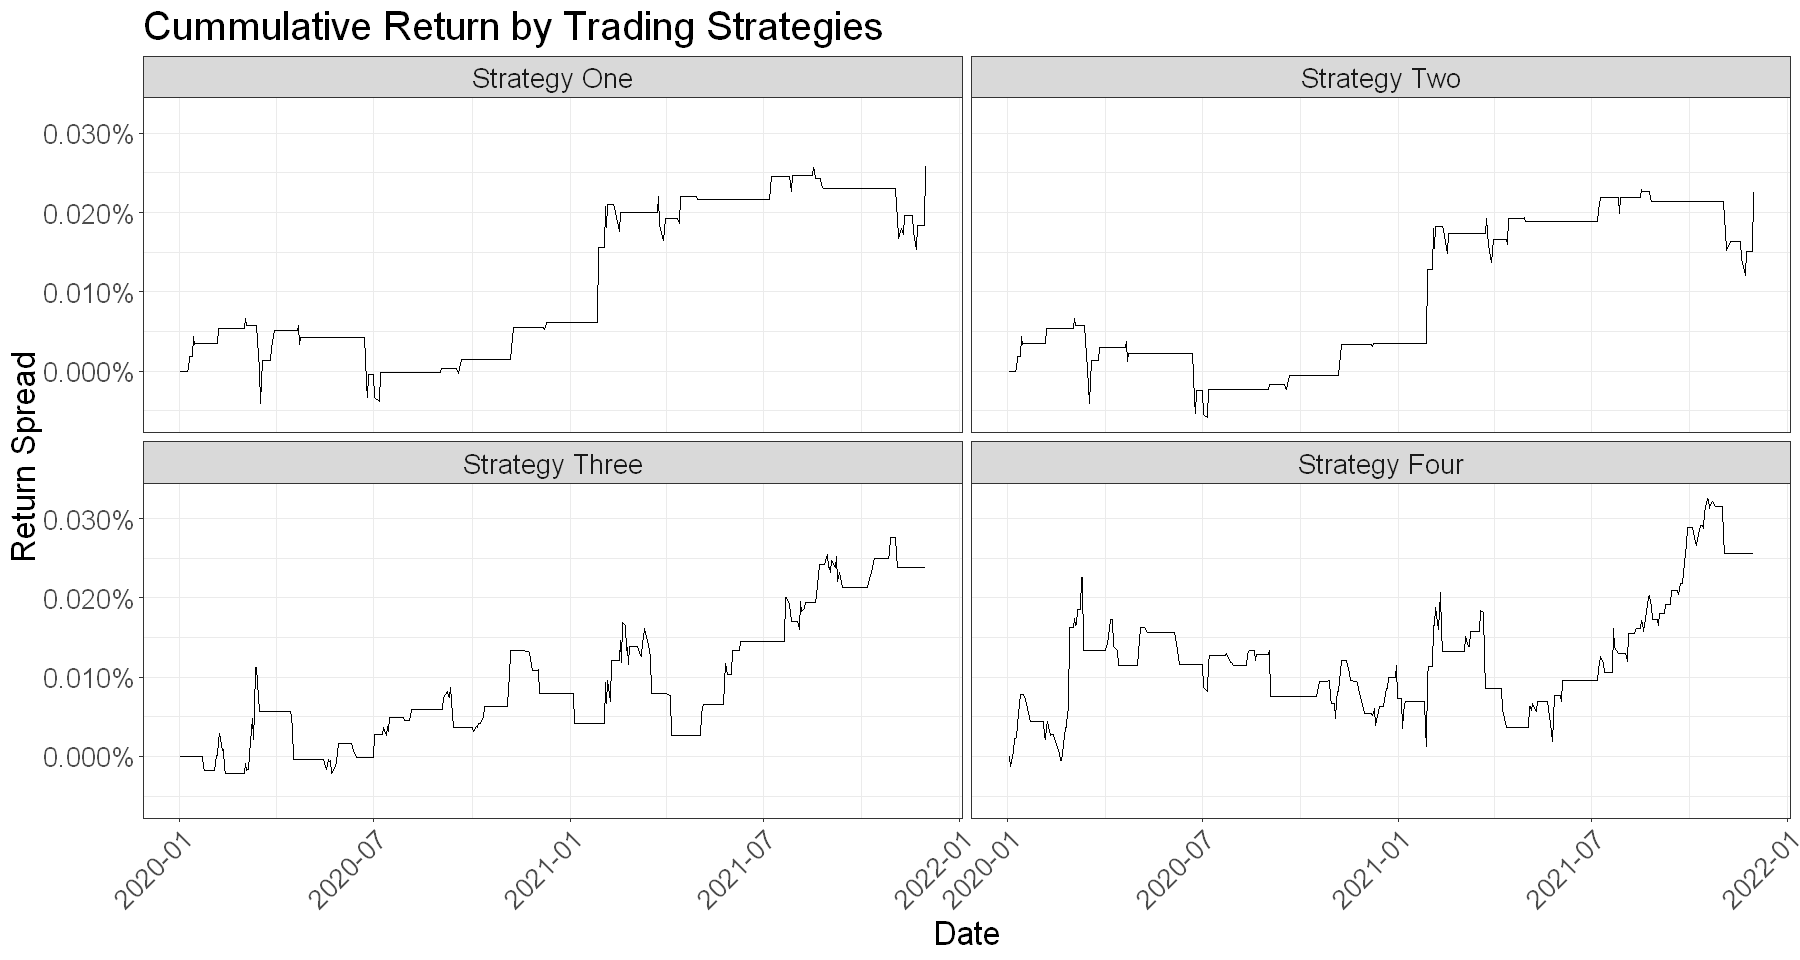

In [8]:
print(spread_range_plot)
print(cummulative_return_plot)

In [9]:
print(performance_metrics_kable)
print(strat_corr_kable)



Table: Top Strategies by Sortino Ratio, Total Return, and Calmar Ratio

|Strategy       |  M|     g|     j|     s| Total Return (%)| Sortino Ratio| Calmar Ratio| Max Drawdown|
|:--------------|--:|-----:|-----:|-----:|----------------:|-------------:|------------:|------------:|
|Strategy One   |  3| 0.030| 0.010| 0.015|        0.0002585|     0.0964892|    1.2593391|    0.0001071|
|Strategy Two   |  3| 0.030| 0.015| 0.015|        0.0002256|     0.0847132|    0.9447413|    0.0001246|
|Strategy Three | 10| 0.025| 0.005| 0.005|        0.0002387|     0.0683558|    0.8730275|    0.0001427|
|Strategy Four  |  5| 0.015| 0.010| 0.010|        0.0002555|     0.0587052|    0.6251537|    0.0002132|


Table: Correlation Of Fama-French Factors and Strategies

|strategy       |  Mkt-RF|    SMB|     HML|     RF|
|:--------------|-------:|------:|-------:|------:|
|Strategy One   | -0.0046| 0.0188|  0.0033| 0.0113|
|Strategy Two   | -0.0101| 0.0203|  0.0060| 0.0008|
|Strategy Three | -0.0644| 0.0170|

**Explaining Results**

 The two etfs we are looking at are PBE (Invesco Dynamic Biotechnology & Genome ETF) and XBI (SPDR S&P Biotech ETF). XBI has a much larger market cap at 6.1 billion compared to PBE at 224 million. XBI is also much more diversified with 190 positions compared to PBE's 40 positions. PBE uses a dynamic factor strategy to find companies based on momentum, quality, and value. XBI equal weights the top biotech companies by market cap. I would expect XBI to outperform when the SMB factor outperforms and PBE to outperform when momentum and value factors outperform. 

To select the parameters to test, I looked at historical returns from 12/03/2018-12/03/2019 to avoid any look ahead bias. I chose to set g close to the top decile of spreads and j close to the bottom quartile of spreads. I chose to do 3-day, 5-day, 10-day, and 15-day returns because it is a good mix of noise and still shows some trends.   

Out of the 135 strategies I tested, I selected the 4 strategies with the highest sortino ratio. All of them had positive returns and very low correlation to the Fama-French factors. If we were only trading when PBE outperformed XBI instead of indifferent on which ETF is outperforming, I would expect the the strategy returns to be much more correlated to the HML factor and negatively correlated with SMB factor. Since we are hoping to exploit mean reversion and are trading both sides of the spread, the low correlations with factors that drive outperformance make sense.